# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка библиотек и данных 

In [2]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00


In [8]:
import warnings
import io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

warnings.simplefilter("ignore")

In [9]:
try:
    data = pd.read_csv('autos.csv')
    
except:
    from google.colab import files
    uploaded = files.upload()
    data = pd.read_csv(io.BytesIO(uploaded['autos.csv']))
    

Saving autos.csv to autos.csv


### Изучение данных, обработка аномалий.

In [10]:
print(data.info())
display(data.head())
print(data.isnull().sum().sort_values(ascending=False).head(10))
print()
data_original = data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Repaired            71154
VehicleType         37490
FuelType            32895
Gearbox             19833
Model               19705
DateCrawled             0
Price                   0
RegistrationYear        0
Power                   0
Kilometer               0
dtype: int64



In [11]:
#убираем полные дубликаты, их всего 4 - там совспадает и время в трех колонках, что маловероятно было случайностью
display(data[data.duplicated()])
print(data.duplicated().sum())
data= data.drop_duplicates()
print(data.info())


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), objec

в данных имеются пропуски в столбцах 

     - Repaired            71154
     - VehicleType         37490
     - FuelType            32895
     - Gearbox             19833
     - Model               19705

некоторые даты представлены в формате строк.
    
Переведем даты в год в формате int для анализа, месяцы выкинем, если по результатам предсказаний их будет недостаточно для достижения показателя точности, вернемся к этому этапу и включим их в данные.

In [12]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    data[col] = pd.to_datetime(data[col], format = '%Y%m%d %H:%M:%S')
    data[col] = data[col].dt.year
    data[col] = data[col].astype(int)
    print(data[col].unique())
print(data.info())
display(data.head(5))


[2016]
[2016 2015 2014]
[2016]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  int64 
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  int64 
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  i

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016,0,70435,2016
1,2016,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,0,66954,2016
2,2016,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,0,90480,2016
3,2016,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,0,91074,2016
4,2016,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,0,60437,2016


из годов для предсказания будет иметь значение только 'DateCreated', остальные пока уберем.

In [13]:
data = data.drop(['DateCrawled', 'LastSeen'], axis = 1)

Предполагается, что данные заполнялись собственниками авто, а они могли не знать какой тип коробки передач, тип кузова или вид топлива правильно поставить. 

Эти пропуски заполним заглушками.

In [14]:
print(data['Repaired'].unique())
print(data['VehicleType'].unique())
print(data['FuelType'].unique())
print(data['Gearbox'].unique())


[nan 'yes' 'no']
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
['manual' 'auto' nan]


In [15]:
data['VehicleType'] = data['VehicleType'].fillna('not_mentioned')
data['FuelType'] = data['FuelType'].fillna('not_mentioned')
data['Gearbox'] = data['Gearbox'].fillna('not_mentioned')
data['Repaired'] = data['Repaired'].fillna('not_mentioned')
data['Model'] = data['Model'].fillna('not_mentioned') 
print(data['Repaired'].unique())
display(data[data['Gearbox'].isna()].head(5))

['not_mentioned' 'yes' 'no']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode


In [16]:
print(data.info())
print(data.isnull().sum().sort_values(ascending=False).head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        354365 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            354365 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              354365 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           354365 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           354365 non-null  object
 11  DateCreated        354365 non-null  int64 
 12  NumberOfPictures   354365 non-null  int64 
 13  PostalCode         354365 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 40.6+ MB
None
Price                0
VehicleType          0
RegistrationYear   

### рассмотрим распределение категориальных признаков, за исключением модели, на предмет аномалий.

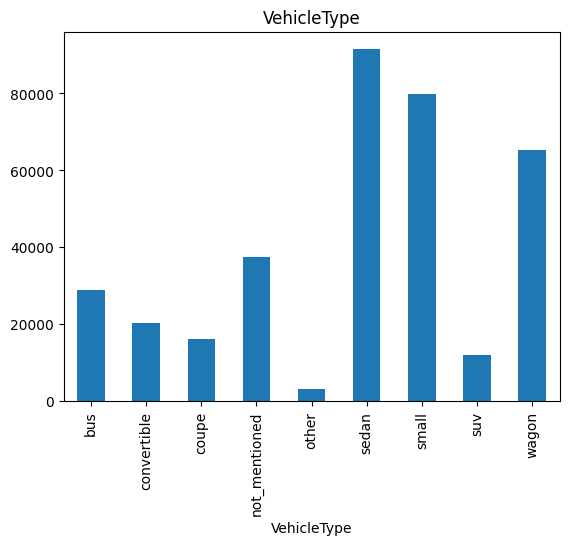

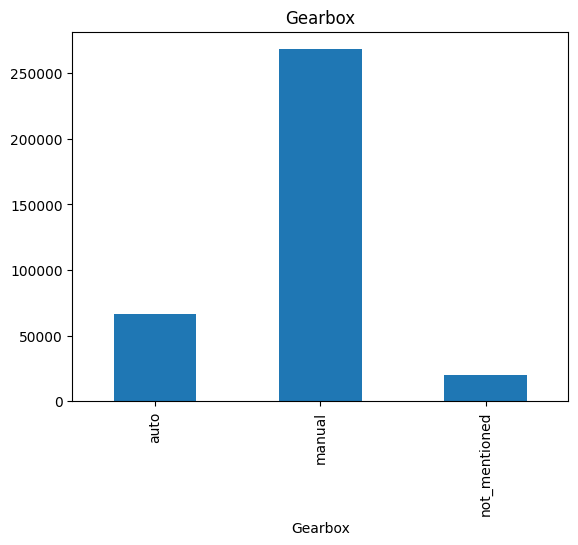

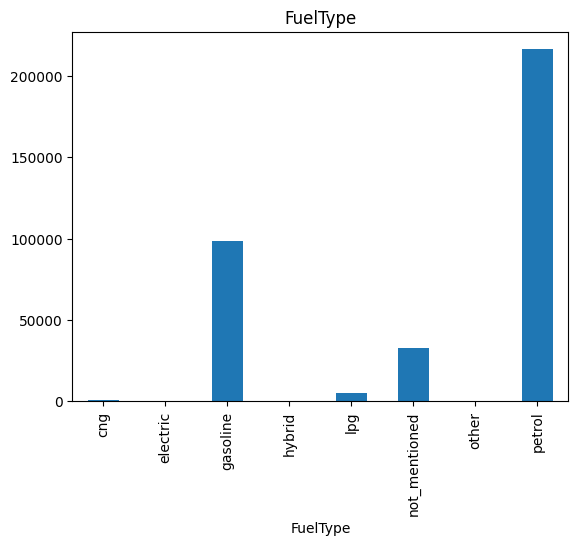

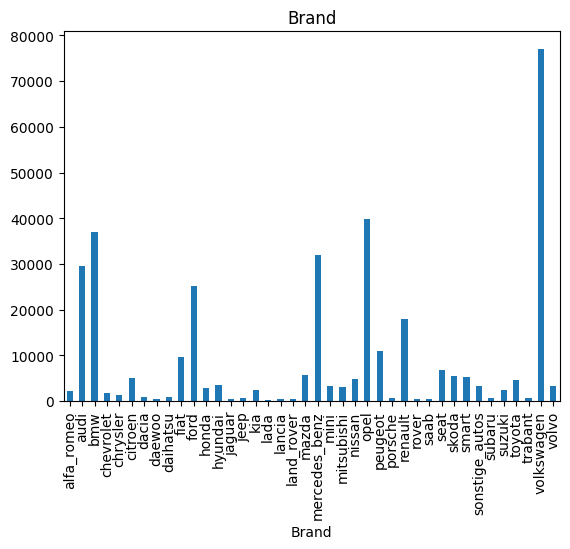

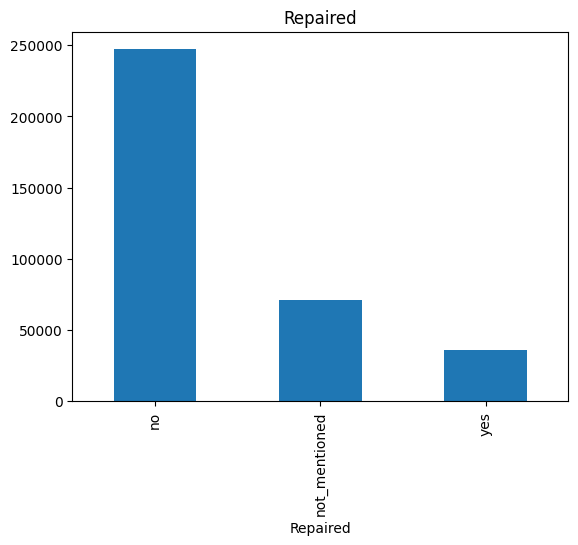

In [17]:
for col in ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']:
    
    data.groupby(col)['Power'].count().plot(kind = 'bar', title = col)
    plt.show()

#### Данных об авто на нежидком топливе немного, закинем их в 'другие'

In [18]:
data[data['FuelType'].isin(['cng', 'hybrid', 'electric', 'others'])]['Price'].count()


888

In [19]:
data.loc[data['FuelType'].isin(['cng', 'hybrid', 'electric', 'lpg']), 'FuelType'] = 'other'
print(data['FuelType'].unique())
display(data.head(5))
print(data.info())

['petrol' 'gasoline' 'not_mentioned' 'other']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode
0,480,not_mentioned,1993,manual,0,golf,150000,0,petrol,volkswagen,not_mentioned,2016,0,70435
1,18300,coupe,2011,manual,190,not_mentioned,125000,5,gasoline,audi,yes,2016,0,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,not_mentioned,2016,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,0,60437


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        354365 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            354365 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              354365 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           354365 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           354365 non-null  object
 11  DateCreated        354365 non-null  int64 
 12  NumberOfPictures   354365 non-null  int64 
 13  PostalCode         354365 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 40.6+ MB
None


#### Рассмортим распределение численных значений

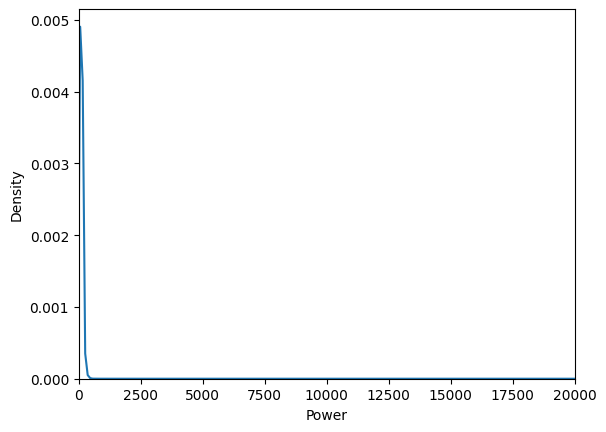

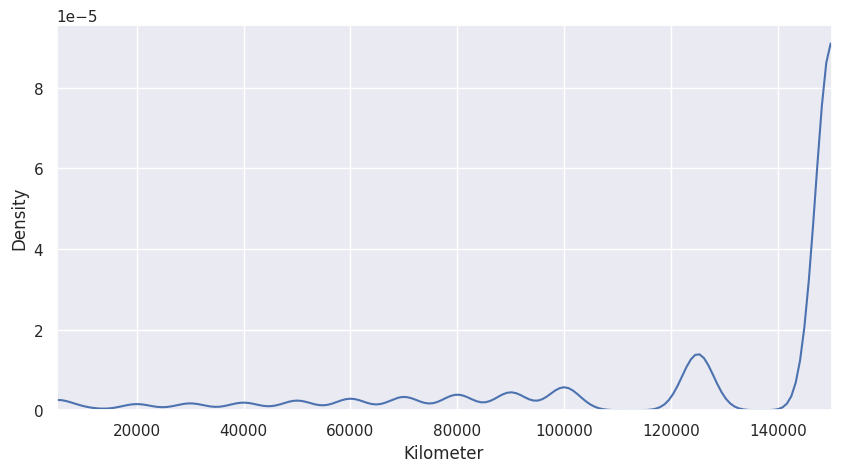

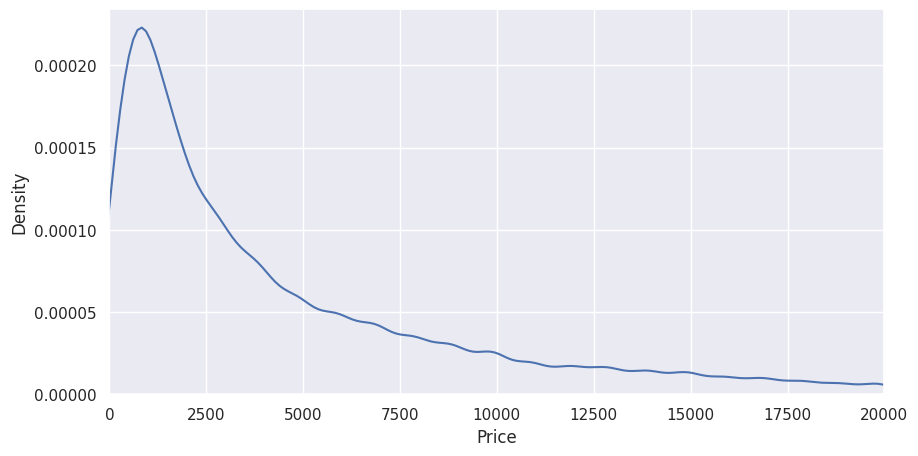

In [20]:
for col in ['Power', 'Kilometer', 'Price']:
    sns.distplot(data[col],
                     label = 'col',
                     hist = False) 
    # Plot formatting
    sns.set(rc = {'figure.figsize':(10,5)})
#    plt.legend(prop={'size': 10}, title = 'datasets')
#    plt.title('rougher.input.feed_size')
 #   plt.xlabel('feed size')
  #  plt.ylabel('number of processes')
    plt.xlim(data[col].min(), data[col].max())
    plt.show()
    #games.hist('year_of_release', bins = 37, range = (1980, 2016))
    #data.disthist(col, bins = 100, figsize = (8, 4))#['Brand'].sum().plot(kind = 'bar')
#    estate.hist('floors_total', bins = 30, range = (0, 30), figsize = (8, 4))


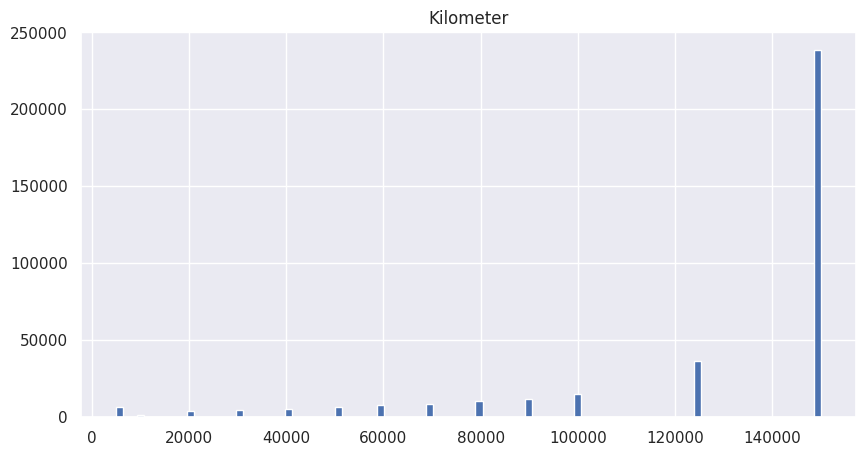

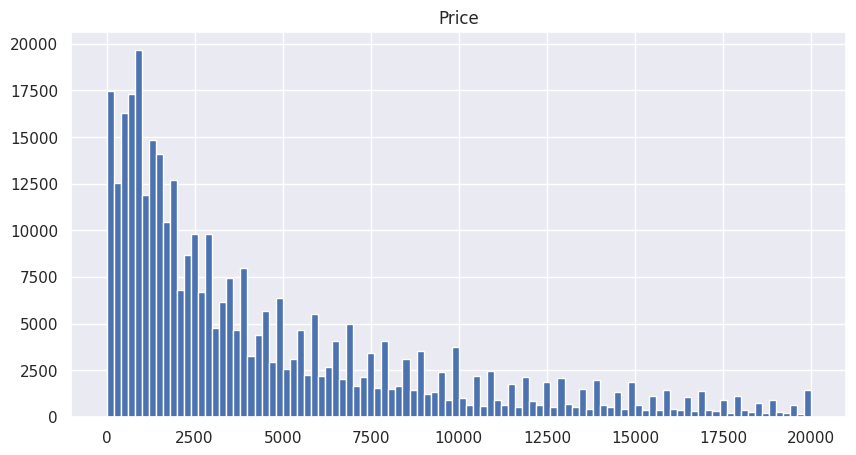

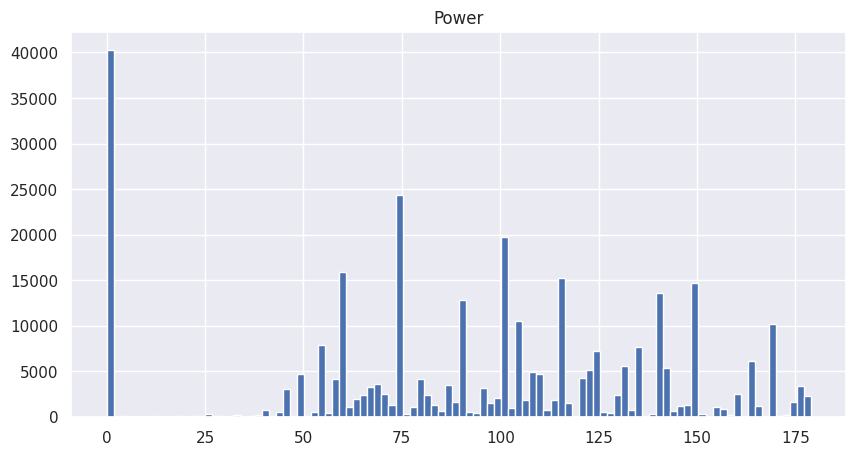

In [21]:
for col in ['Kilometer', 'Price']:
    data.hist(col, bins = 100, range = (data[col].min(), data[col].max()))
    plt.show()
data.hist('Power', bins = 100, range = (data['Power'].min(), data['Power'].quantile(0.9)))
plt.show()

In [22]:
print(data[data['Power'] ==0]['Power'].count())
print(data[data['Price'] ==0]['Price'].count())
print(data['RegistrationYear'].unique())
print(data[data['RegistrationYear'] <1886]['RegistrationYear'].count())
print(data[data['RegistrationYear'] >2020]['RegistrationYear'].count())
print(data[data['RegistrationYear'] ==2020]['RegistrationYear'].count())
print(data[data['RegistrationYear'] >2019]['RegistrationYear'].unique())
display(data[(data['RegistrationYear'] >1886) & (data['RegistrationYear'] <1930)])

40225
10772
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]
66
105
0
[5000 9999 3200 8888 2200 4100 3000 2066 8000 5300 9000 2900 6000 5900
 5911 4000 8500 3700 3800 4800 7000 6500 2290 2500 9450 2800 5555 5600
 2222 9996 8455 4500 7800 9229 7100 8200 7500 3500]


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode
15,450,small,1910,not_mentioned,0,ka,5000,0,petrol,ford,not_mentioned,2016,0,24148
2273,1800,convertible,1925,not_mentioned,0,not_mentioned,5000,1,not_mentioned,sonstige_autos,no,2016,0,79288
6629,0,small,1910,not_mentioned,0,not_mentioned,5000,1,other,sonstige_autos,not_mentioned,2016,0,93105
6977,135,not_mentioned,1910,not_mentioned,0,not_mentioned,5000,0,not_mentioned,opel,not_mentioned,2016,0,19374
10183,1250,not_mentioned,1910,not_mentioned,0,other,5000,0,not_mentioned,audi,not_mentioned,2016,0,18445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333004,0,suv,1910,manual,0,not_mentioned,5000,0,not_mentioned,toyota,not_mentioned,2016,0,48683
334901,1300,not_mentioned,1910,not_mentioned,0,not_mentioned,5000,9,not_mentioned,audi,not_mentioned,2016,0,82256
336104,20000,coupe,1929,manual,12,other,10000,4,petrol,bmw,not_mentioned,2016,0,74523
343083,1,other,1910,not_mentioned,0,not_mentioned,5000,1,other,volkswagen,not_mentioned,2016,0,18273


In [23]:
# убираем авто с неадекватными годами
data = data[data['RegistrationYear'] > 1886]
data = data[data['RegistrationYear'] < 2020]

In [24]:
#убираем данные с нулевой мощьностью
data = data[data['Power'] >0]
print(data[data['Power'] >= 500]['Brand'].count())

485


In [25]:
data = data[data['Power'] <500]

нулевая цена - это скорее всего ошибка в заполнении, возможно был какой-то сбой в системе, от этих данных придется избавится. Оставим от 100 евро, возможно кто-то хочет просто избавиться от гнилого металла во дворе. Так же пришлось выбросить данные с нулевой мощьностью и годами меньше 1886 и ббольше 2020

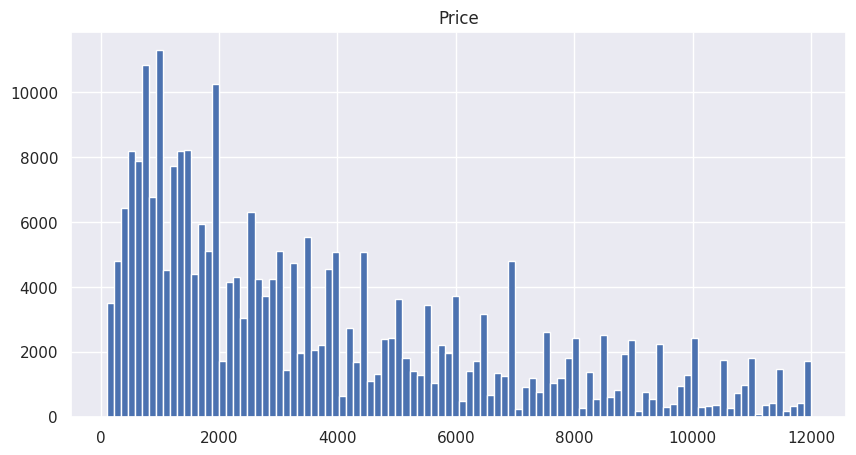

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304890 entries, 1 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              304890 non-null  int64 
 1   VehicleType        304890 non-null  object
 2   RegistrationYear   304890 non-null  int64 
 3   Gearbox            304890 non-null  object
 4   Power              304890 non-null  int64 
 5   Model              304890 non-null  object
 6   Kilometer          304890 non-null  int64 
 7   RegistrationMonth  304890 non-null  int64 
 8   FuelType           304890 non-null  object
 9   Brand              304890 non-null  object
 10  Repaired           304890 non-null  object
 11  DateCreated        304890 non-null  int64 
 12  NumberOfPictures   304890 non-null  int64 
 13  PostalCode         304890 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 34.9+ MB
None


In [26]:
data = data[data['Price'] > 100]
data.hist('Price', bins = 100, range = (data['Price'].min(), data['Price'].quantile(0.9)))
plt.show()
print(data.info())

#### Категориальные признаки преобразуем для анализа регрессорами. К сожалению, модели создают очень большой массив данных, там много пропусков, попробуем обучение без них.

In [27]:
# сохраним с кат признаками, чтобы использовать потом в CATboost
data_cat = data.copy()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304890 entries, 1 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              304890 non-null  int64 
 1   VehicleType        304890 non-null  object
 2   RegistrationYear   304890 non-null  int64 
 3   Gearbox            304890 non-null  object
 4   Power              304890 non-null  int64 
 5   Model              304890 non-null  object
 6   Kilometer          304890 non-null  int64 
 7   RegistrationMonth  304890 non-null  int64 
 8   FuelType           304890 non-null  object
 9   Brand              304890 non-null  object
 10  Repaired           304890 non-null  object
 11  DateCreated        304890 non-null  int64 
 12  NumberOfPictures   304890 non-null  int64 
 13  PostalCode         304890 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 34.9+ MB
None


In [28]:
data = data.drop('Model', axis =1)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304890 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              304890 non-null  int64 
 1   VehicleType        304890 non-null  object
 2   RegistrationYear   304890 non-null  int64 
 3   Gearbox            304890 non-null  object
 4   Power              304890 non-null  int64 
 5   Kilometer          304890 non-null  int64 
 6   RegistrationMonth  304890 non-null  int64 
 7   FuelType           304890 non-null  object
 8   Brand              304890 non-null  object
 9   Repaired           304890 non-null  object
 10  DateCreated        304890 non-null  int64 
 11  NumberOfPictures   304890 non-null  int64 
 12  PostalCode         304890 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 32.6+ MB
None


от исходных 354 тысяч строк осталось 305 - немного больше 85%. посмотрим на обучаемость моделей.

In [29]:
print(data['NumberOfPictures'].unique())
print(data[data['NumberOfPictures']>0])

[0]
Empty DataFrame
Columns: [Price, VehicleType, RegistrationYear, Gearbox, Power, Kilometer, RegistrationMonth, FuelType, Brand, Repaired, DateCreated, NumberOfPictures, PostalCode]
Index: []


In [30]:
data = data.drop('NumberOfPictures', axis = 1)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304890 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              304890 non-null  int64 
 1   VehicleType        304890 non-null  object
 2   RegistrationYear   304890 non-null  int64 
 3   Gearbox            304890 non-null  object
 4   Power              304890 non-null  int64 
 5   Kilometer          304890 non-null  int64 
 6   RegistrationMonth  304890 non-null  int64 
 7   FuelType           304890 non-null  object
 8   Brand              304890 non-null  object
 9   Repaired           304890 non-null  object
 10  DateCreated        304890 non-null  int64 
 11  PostalCode         304890 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 30.2+ MB
None


Промежуточный вывод:
    
* предоставленные данные содержали много пропусков и ошибок, к сожалению из-за них пришлось отказаться от 15% массива. 

* форматы дат были переведены в числовой, от некоторых параметров мы отказались ввиду их несодержательности.

* некоторые категориальные параметры были объединены для упрощения анализа.

* от информации о моделях автомобиля пришлось отказаться.

* возможно, есть смысл переработать форму подачи объявления, а в частности:
  * километраж сделать цифровым полем
  * год выпуска в виде выпадающего меню
  * заполнение дат автоматизировать в формате DateTime

## Обучение моделей

### Подготовьте выборки для обучения моделей.

In [31]:
features = data.drop(['Price'], axis = 1)
target = data['Price']
rand_value = 12345
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=rand_value)#, stratify=target)
    
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=rand_value)
print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)
print(target_valid.shape)
print(target_train.shape)
print(target_test.shape)
features_original, target_original = features.copy(), target.copy()

(182934, 11)
(60978, 11)
(60978, 11)
(60978,)
(182934,)
(60978,)


In [32]:
print(features_train.info())
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
print(ohe_features)
print(num_features)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182934 entries, 165178 to 77494
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        182934 non-null  object
 1   RegistrationYear   182934 non-null  int64 
 2   Gearbox            182934 non-null  object
 3   Power              182934 non-null  int64 
 4   Kilometer          182934 non-null  int64 
 5   RegistrationMonth  182934 non-null  int64 
 6   FuelType           182934 non-null  object
 7   Brand              182934 non-null  object
 8   Repaired           182934 non-null  object
 9   DateCreated        182934 non-null  int64 
 10  PostalCode         182934 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 16.7+ MB
None
['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']
['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'DateCreated', 'PostalCode']


### Создаем Scaler

In [33]:
# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])
print(features_train[num_features])

        RegistrationYear     Power  Kilometer  RegistrationMonth  DateCreated  \
165178         -0.335906  0.936548   0.587213           0.839690      0.00964   
192213         -0.335906  0.936548   0.587213          -1.665040      0.00964   
84515           0.818961  2.101207   0.587213          -1.108433      0.00964   
159736          0.674603 -0.829224   0.587213           1.117994      0.00964   
334959         -0.480264 -1.167351   0.587213           1.396297      0.00964   
...                  ...       ...        ...                ...          ...   
120851          1.107678  0.429358  -1.598941          -1.108433      0.00964   
197900          0.385886 -0.998287  -1.598941           0.839690      0.00964   
183310          0.097169  0.654776   0.587213           1.674600      0.00964   
130128          0.241528 -1.129781   0.587213          -0.273523      0.00964   
77494          -0.913339 -0.077832   0.587213           1.117994      0.00964   

        PostalCode  
165178

In [34]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)
display(features_train)

,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_not_mentioned,VehicleType_other,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_not_mentioned,Repaired_yes
165178,-0.335906,0.936548,0.587213,0.839690,0.00964,0.046565,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192213,-0.335906,0.936548,0.587213,-1.665040,0.00964,0.636362,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84515,0.818961,2.101207,0.587213,-1.108433,0.00964,0.546511,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159736,0.674603,-0.829224,0.587213,1.117994,0.00964,-0.458311,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
334959,-0.480264,-1.167351,0.587213,1.396297,0.00964,0.545385,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120851,1.107678,0.429358,-1.598941,-1.108433,0.00964,0.510221,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197900,0.385886,-0.998287,-1.598941,0.839690,0.00964,0.197662,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183310,0.097169,0.654776,0.587213,1.674600,0.00964,-1.817725,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130128,0.241528,-1.129781,0.587213,-0.273523,0.00964,0.269272,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Обучим модели.

#### для начала попробуем LinearRegressor и DecisionTreeRegressor

In [35]:
%%time
#classic LinearRegressor

line = LinearRegression()
line.fit(features_train, target_train)

CPU times: user 1.62 s, sys: 548 ms, total: 2.17 s
Wall time: 2.16 s


LinearRegression()

In [36]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем валидационную
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем валидационную
features_valid[num_features] = scaler.transform(
    features_valid[num_features]
)

# смотрим на результат
features_valid.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_not_mentioned,VehicleType_other,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_not_mentioned,Repaired_yes
142239,1.107678,-0.284465,-2.692017,0.561387,0.00964,0.106763,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
99634,-0.191547,-0.077832,0.587213,-0.551827,0.00964,-0.213015,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260374,-0.191547,-0.754085,-0.779133,-0.551827,0.00964,1.328354,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344549,0.674603,-0.284465,0.587213,-1.108433,0.00964,-0.951387,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
273071,-0.480264,2.721105,0.587213,0.004780,0.00964,-0.457457,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
%%time
predict = line.predict(features_valid)
print(mean_squared_error(target_valid, predict, squared = False))

2749.891401212385
CPU times: user 26.7 ms, sys: 1.46 ms, total: 28.1 ms
Wall time: 25.1 ms


In [38]:
%%time
#DecisionTreeRegressor

tree_param = {
            'max_depth': [5, 10, 20],
            'min_samples_leaf': [5, 10, 20],
            'min_samples_split': [5, 10, 20]
            }

grid = GridSearchCV(
                    DecisionTreeRegressor(random_state=rand_value), 
                    param_grid = tree_param, 
                    cv=5, 
                    scoring='neg_root_mean_squared_error'
                    )
grid.fit(features_train, target_train)
%time #измеряет время предыдущей операции
print(grid.best_estimator_)
print(grid.best_score_)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
DecisionTreeRegressor(max_depth=20, min_samples_leaf=20, min_samples_split=5,
                      random_state=12345)
-1863.6227868503252
CPU times: user 2min 51s, sys: 1.46 s, total: 2min 52s
Wall time: 2min 55s


In [39]:
%%time
tree = DecisionTreeRegressor(
                            max_depth=20, 
                            min_samples_leaf=20, 
                            min_samples_split=5,
                            random_state=12345
                            )
tree.fit(features_train, target_train)

CPU times: user 1.97 s, sys: 1.87 ms, total: 1.97 s
Wall time: 1.97 s


DecisionTreeRegressor(max_depth=20, min_samples_leaf=20, min_samples_split=5,
                      random_state=12345)

In [40]:
%%time
tree_pred = tree.predict(features_valid)

print('RMSE', mean_squared_error(target_valid, tree_pred, squared = False))

RMSE 1861.0664850275505
CPU times: user 31.3 ms, sys: 0 ns, total: 31.3 ms
Wall time: 29.8 ms


    Вывод по DTR: на валидационной выборке
    RMSE  1861.0664850275505
    время предсказания Wall time: 32.8 ms
    время обучения Wall time: 2.12 s

#### Проверим CatBoostRegressor

In [41]:
features = data.drop(['Price'], axis = 1)
target = data['Price']
rand_value = 12345
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=rand_value)#, stratify=target)
    
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=rand_value)
print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)
print(target_valid.shape)
print(target_train.shape)
print(target_test.shape)
features_original, target_original = features.copy(), target.copy()

(182934, 11)
(60978, 11)
(60978, 11)
(60978,)
(182934,)
(60978,)


In [42]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ord.fit(features_train[ohe_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ord.get_feature_names_out()
] = encoder_ord.transform(features_train[ohe_features])

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

display(features_train)

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
165178,8.0,-0.335906,2.0,0.936548,0.587213,0.839690,3.0,2.0,0.0,0.00964,0.046565
192213,2.0,-0.335906,0.0,0.936548,0.587213,-1.665040,1.0,2.0,0.0,0.00964,0.636362
84515,5.0,0.818961,0.0,2.101207,0.587213,-1.108433,0.0,1.0,0.0,0.00964,0.546511
159736,6.0,0.674603,1.0,-0.829224,0.587213,1.117994,2.0,27.0,0.0,0.00964,-0.458311
334959,6.0,-0.480264,1.0,-1.167351,0.587213,1.396297,3.0,27.0,0.0,0.00964,0.545385
...,...,...,...,...,...,...,...,...,...,...,...
120851,5.0,1.107678,1.0,0.429358,-1.598941,-1.108433,0.0,2.0,0.0,0.00964,0.510221
197900,6.0,0.385886,1.0,-0.998287,-1.598941,0.839690,3.0,3.0,0.0,0.00964,0.197662
183310,8.0,0.097169,1.0,0.654776,0.587213,1.674600,3.0,24.0,0.0,0.00964,-1.817725
130128,3.0,0.241528,2.0,-1.129781,0.587213,-0.273523,3.0,24.0,1.0,0.00964,0.269272


In [43]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем валидационную
features_valid[
    encoder_ord.get_feature_names_out()
] = encoder_ord.transform(features_valid[ohe_features])

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем валидационную
features_valid[num_features] = scaler.transform(
    features_valid[num_features]
)

# смотрим на результат
features_valid.head()

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
142239,8.0,1.107678,1.0,-0.284465,-2.692017,0.561387,3.0,38.0,0.0,0.00964,0.106763
99634,5.0,-0.191547,1.0,-0.077832,0.587213,-0.551827,0.0,20.0,0.0,0.00964,-0.213015
260374,6.0,-0.191547,1.0,-0.754085,-0.779133,-0.551827,3.0,9.0,0.0,0.00964,1.328354
344549,0.0,0.674603,1.0,-0.284465,0.587213,-1.108433,0.0,38.0,0.0,0.00964,-0.951387
273071,7.0,-0.480264,0.0,2.721105,0.587213,0.004780,3.0,10.0,0.0,0.00964,-0.457457


In [ ]:
%%time

# CatBoostRegressor
cat_param = {
            'depth'         : [6,8,10],
            'learning_rate' : [0.01, 0.05, 0.1],
            'iterations'    : [30, 50, 100]
            }

grid = GridSearchCV(
                    CatBoostRegressor(loss_function = 'RMSE'), 
                    param_grid = cat_param, 
                    cv=5, 
                    scoring='neg_root_mean_squared_error'
                    )

grid.fit(features_train, target_train)

print(grid.best_estimator_) 
print(np.abs(grid.best_score_))
print(grid.best_params_)

In [45]:
cbr = grid.best_estimator_

In [46]:
%%time
cbr.fit(features_train, target_train)

0:	learn: 4253.8020387	total: 70.5ms	remaining: 6.98s
1:	learn: 3963.7205914	total: 135ms	remaining: 6.63s
2:	learn: 3708.2590821	total: 203ms	remaining: 6.57s
3:	learn: 3486.7374778	total: 267ms	remaining: 6.41s
4:	learn: 3291.8632623	total: 337ms	remaining: 6.41s
5:	learn: 3118.5760688	total: 401ms	remaining: 6.28s
6:	learn: 2965.1600506	total: 464ms	remaining: 6.16s
7:	learn: 2832.8733087	total: 526ms	remaining: 6.05s
8:	learn: 2717.6541218	total: 593ms	remaining: 6s
9:	learn: 2613.5043493	total: 659ms	remaining: 5.93s
10:	learn: 2522.7115885	total: 721ms	remaining: 5.83s
11:	learn: 2444.0123769	total: 784ms	remaining: 5.75s
12:	learn: 2375.1558753	total: 853ms	remaining: 5.71s
13:	learn: 2311.5489517	total: 926ms	remaining: 5.69s
14:	learn: 2257.7195917	total: 1s	remaining: 5.67s
15:	learn: 2211.9492161	total: 1.07s	remaining: 5.65s
16:	learn: 2171.8723097	total: 1.17s	remaining: 5.72s
17:	learn: 2138.2701784	total: 1.24s	remaining: 5.63s
18:	learn: 2105.7325922	total: 1.3s	remaini

In [47]:
%%time
cbr_pred = cbr.predict(features_valid)
print('RMSE', mean_squared_error(target_valid, cbr_pred, squared = False))

RMSE 1729.8146341985312
CPU times: user 60.8 ms, sys: 15 ms, total: 75.8 ms
Wall time: 49.5 ms


    Вывод по CBR: на валидационной выборке
    RMSE 1729.8146341985312
    время предсказания Wall time: 31.2 ms
    время обучения Wall time: 6.5 s

### Проверим lightgbm

In [48]:
%%time
lgb_model = LGBMRegressor()

lgb_model.fit(features_train, target_train) 

CPU times: user 2.73 s, sys: 18.6 ms, total: 2.75 s
Wall time: 1.48 s


LGBMRegressor()

In [49]:
%%time
preds_lgb_model = lgb_model.predict(features_valid)

print("RMSE" , np.sqrt(mean_squared_error(target_valid, preds_lgb_model)))

RMSE 1728.4559659974962
CPU times: user 614 ms, sys: 1.97 ms, total: 616 ms
Wall time: 334 ms


In [50]:
%%time

#LightGBM
lgbm_param = {
            'n_estimators'  : [50, 100],
            'num_leaves'    : [50, 100]
            #'learning_rate' : [0.1]
            }
lgbm_model = LGBMRegressor()
grid = GridSearchCV(
                    LGBMRegressor(learning_rate = 0.1), 
                    param_grid = lgbm_param, 
                    cv=5, 
                    scoring='neg_root_mean_squared_error'
                    )

grid.fit(features_train, target_train)


print(grid.best_estimator_) 
print(grid.best_score_)
print(grid.best_params_)


LGBMRegressor(num_leaves=100)
-1649.43445146279
{'n_estimators': 100, 'num_leaves': 100}
CPU times: user 1min 6s, sys: 353 ms, total: 1min 7s
Wall time: 45.7 s


In [51]:
%%time
lgbm_fin = grid.best_estimator_
lgbm_fin.fit(features_train, target_train)


CPU times: user 6.25 s, sys: 35.5 ms, total: 6.28 s
Wall time: 4.99 s


LGBMRegressor(num_leaves=100)

In [52]:
%%time
lgbm_pred = lgbm_fin.predict(features_valid)

print('RMSE lgbm', np.sqrt(mean_squared_error(target_valid, lgbm_pred)))

RMSE lgbm 1650.5269663653248
CPU times: user 768 ms, sys: 3.79 ms, total: 772 ms
Wall time: 432 ms


    Вывод по LGBM: на валидационной выборке
    RMSE  1650.5269663653248
    время предсказания Wall time: 710 ms
    время обучения Wall time: 8.79 s

## Анализ моделей

* по требованию заказчика, RMSE не должна превышать 2500. Этот порог проходят 3 модели:
1. DecisionTreeRegressor(max_depth=20, min_samples_leaf=20, min_samples_split=5, random_state=12345)
    <br>RMSE  1861.0664850275505
    <br>время предсказания Wall time: 32.8 ms
    <br>время обучения Wall time: 2.12 s
                      
2. CatBoostRegressor {'depth': 10, 'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'RMSE'} 
    <br>RMSE 1729.8146341985312
    <br>время предсказания Wall time: 31.2 ms
    <br>время обучения Wall time: 6.5 s
    
3. LGBMRegressor {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 100}
    <br>RMSE  1650.5269663653248
    <br>время предсказания Wall time: 710 ms
    <br>время обучения Wall time: 8.79 s


LGBMRegressor дал наиболее точные предсказания при незнчительных изменениях по времени.

## Проверим выбранную модель на тестовой выборке

In [53]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[encoder_ord.get_feature_names_out()] = encoder_ord.transform(features_test[ohe_features])

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем валидационную
features_test[num_features] = scaler.transform(
    features_test[num_features])

# смотрим на результат
features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
99341,4.0,0.530244,1.0,0.373004,0.587213,1.674600,0.0,38.0,0.0,0.00964,-1.575806
109935,5.0,0.530244,1.0,0.373004,-0.095960,-1.108433,3.0,38.0,0.0,0.00964,-0.075889
261299,0.0,-0.047189,1.0,-0.340819,-0.095960,-0.273523,3.0,38.0,1.0,0.00964,0.573719
139911,8.0,-0.191547,1.0,-0.359604,0.587213,-0.273523,3.0,19.0,0.0,0.00964,0.204649
66757,6.0,-0.335906,1.0,-1.317629,0.587213,1.396297,1.0,38.0,1.0,0.00964,0.008606


In [54]:
%%time
lgbm_fin_pred = lgbm_fin.predict(features_test)

print('RMSE', mean_squared_error(target_test, lgbm_fin_pred, squared = False))

RMSE 1657.7600191451666
CPU times: user 751 ms, sys: 834 µs, total: 752 ms
Wall time: 393 ms


### Вывод

        Согласно заданию, необходимо было построить модель предсказания стоимости автомобиля. Основные параметры: точность по RMSE, время обучения и время предсказания.
    
    Для этого были предоставлены данные о 354 тысячах автомоблией. в данных были пропуски, даты были в формате str, данные о мощности и цене некоторых автомобилей были равны 0. В дальнейшем стоит проработать эти артефакты, выяснить и устранить причину заполнения данных неверными значениями.
    * описанные артефакты были устранены разными способами, данные подготовлены для обучения моделей регрессии.
    
    Для предсказания стоимости были предложены следующие модели: 
    1. DecisionTreeRegressor(max_depth=20, min_samples_leaf=20, min_samples_split=5, random_state=12345)
    2. CatBoostRegressor {'depth': 10, 'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'RMSE'} 
    3. LGBMRegressor {'learning_rate': 0.2, 'n_estimators': 100, 'num_leaves': 100} 
    
    Для использования рекомендуется модель LGBMRegressor {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 100}, потому что она показывает лучшие результаты.